# 2_ Predicción/ Prediction Notebook



In [1]:
import os
import glob
from tqdm import tqdm
import subprocess

In [2]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
from satproc.postprocess.polygonize import polygonize 
from satproc.filter import filter_by_max_prob

### **Declaración de variables/ Variables statement**

In [3]:
#General
YEAR="2022" #year of the training image
YEAR_PREDICT = "2022"
ZONE = "BH"


#Bucket
#VM 
BUCKET_IMG = f"gs://dym-org-techo-temp/techo-brasil/imagenes/{ZONE}/{YEAR_PREDICT}/*.tif" 
BUCKET_MOD = f"gs://dym-org-techo-temp/techo-brasil/data/weights/model/zona_train_UNet_techo_4D_spe100_img160_size160_sz30.h5" 



#Colab
#BUCKET_IMG = f"gs://dym-datasets-public/techo-brasil/imagenes/{ZONE}/{YEAR_PREDICT}/*.tif" 
#BUCKET_MOD = f"gs://dym-datasets-public/techo-brasil/data/weights/model/zona_train_UNet_techo_4D_spe100_img192_size192_sz30.h5" 




#Paths
BASE_PATH = "./.."
PATH_PREDICT_IMAGES = f'{BASE_PATH}/images/{ZONE}/{YEAR_PREDICT}/'

DEBUG = True

In [50]:
#Satproc
SIZE =160
#STEP_SIZE = 40
STEP_SIZE = SIZE
AOI_PREDICT = "aoi_asentamientos_v2_brasil_buffer_2000_4326.geojson"
RESCALE_MODE = "values --min 0 --max 0.3"    

#train
INFO = "classA"

#unet
INPUT_SIZE=160
N_CHANNELS=4
N_CLASSES = 1
CLASS_WEIGHT = [1]
STEP_PER_EPOCH = 100
VERSION='v1' 
VERSION_UNET='v1' 
  
#Post-process
THR=0.3
min_area = 500 #CHECK value if the resolution changes         

### Descarga desde buckets/ Download from buckets

**Descarga de imágenes**  
*Images download*

In [5]:
!gsutil ls $BUCKET_IMG

gs://dym-org-techo-temp/techo-brasil/imagenes/BH/2022/0000000000-0000014848.tif
gs://dym-org-techo-temp/techo-brasil/imagenes/BH/2022/0000000000-0000029696.tif


In [5]:
folder =PATH_PREDICT_IMAGES

!mkdir -p $folder

!gsutil -m cp -r $BUCKET_IMG $folder

Copying gs://dym-quilmes-trucks-temp/I2UD/imagenes/sula/low/2021/2021_RGB_anual_median_.tif...
/ [1/1 files][914.2 MiB/914.2 MiB] 100% Done  38.3 MiB/s ETA 00:00:00           
Operation completed over 1 objects/914.2 MiB.                                    




## Generación del data set de predicción / Prediction dataset generation

### Satproc

Con esta herramienta generamos un dataset de imágenes de predicción que, a diferencia del de entrenamiento, solo contiene imágenes.

*This tool is also used to generate the predict dataset which only has images.*

Pasamos la ruta de las imágenes de predicción y la ruta donde queremos que se guarde el resultado.

*We define the predict dataset  and the prediction images paths*

In [10]:
path_to_files   = f'{PATH_PREDICT_IMAGES}*.tif' #carpeta a las imagenes
output_folder   = f'{BASE_PATH}/dataset/data_predict/{ZONE}/{YEAR_PREDICT}/{VERSION_UNET}/{str(SIZE)}_{str(STEP_SIZE)}/' #carpeta de destino del dataset
vector_file_aoi = f'{BASE_PATH}/data/shp/gt/{ZONE}/{AOI_PREDICT}' #archivo vectorial con las zonas de interes

In [13]:
print(path_to_files, output_folder)

./../images/BH/2022/*.tif ./../dataset/data_predict/BH/2022/v1/160_160/


**Obs**: Dado que aquí nos interesa predecir sobre toda la imágen y por ende no tener overlaps,  *step_size* debe ser igual a *size*.

*Here, we are interested in predict over the whole image and without overlap, then the size and step_size must be equals.*

In [ ]:
#!satproc_extract_chips --help

In [14]:
!satproc_extract_chips \
                $path_to_files \
                -o  $output_folder \
                --aoi $vector_file_aoi \
                --size $SIZE \
                --step-size $SIZE \
                --rescale \
                --rescale-mode $RESCALE_MODE

Rasters: 100%|####################################| 2/2 [00:03<00:00,  1.81s/it]


## Prediccion/Prediction

Definimos la configuración para la predicción. Debemos pasar la ruta de las imágenes en el dataset de predicción, que es la ruta de salida de la línea anterior, y la correspondiente al modelo que entrenamos.

*The prediction configuration is defined. We have to pass the prediction dataset path and the model path.*

In [15]:
#download model from bkt
folder_mod = f'{BASE_PATH}/data/weights/model/'

!mkdir -p $folder_mod
!gsutil -m cp -r $BUCKET_MOD $folder_mod
#!gsutil -m cp -r $BUCKET_IMG $folder

Copying gs://dym-org-techo-temp/techo-brasil/data/weights/model/zona_train_UNet_techo_4D_spe100_img160_size160_sz30.h5...
| [1/1 files][356.3 MiB/356.3 MiB] 100% Done                                    
Operation completed over 1 objects/356.3 MiB.                                    


In [16]:
#model_name = f'UNet_{ZONE}_{INPUT_SIZE}x{INPUT_SIZE}_{str(SIZE)}_{str(STEP_SIZE)}_spe{str(STEP_PER_EPOCH)}_{N_CHANNELS}N_fecha{YEAR}_{INFO}_{VERSION_UNET}.h5'
model_name = 'zona_train_UNet_techo_4D_spe100_img160_size160_sz30.h5'
model_name

'zona_train_UNet_techo_4D_spe100_img160_size160_sz30.h5'

In [17]:
predict_config = PredictConfig(
                            images_path=output_folder, # ruta a las imagenes sobre las cuales queremos predecir
                            results_path=os.path.join(BASE_PATH,'dataset/data_results',ZONE,YEAR_PREDICT,VERSION_UNET,str(SIZE)+"_"+str(STEP_SIZE)), #'modelo_'+VERSION ruta de destino para nuestra predicción
                            batch_size=16,
                            model_path=os.path.join(BASE_PATH,'data/weights/model',model_name),  #  ruta al modelo (.h5)
                            height=INPUT_SIZE,
                            width=INPUT_SIZE,
                            n_channels = N_CHANNELS,
                            n_classes  = N_CLASSES,
                            class_weights = CLASS_WEIGHT)


A continuación ejecutamos la predicción.

*Running the prediction process.*

In [19]:
predict(predict_config)  # Ejecuta la predicción

Total images to predict (./../dataset/data_predict/BH/2022/v1/160_160/images/*.tif): 361
After skipping existing results: 361


  0%|          | 0/23 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████| 23/23 [00:46<00:00,  2.02s/it]

Done!


In [27]:
#!ls ../data/weights/

Podemos ver algunos resultados preliminares de la predicción. A la izquierda se encuentra la imágen y a la derecha, la predicción.

*The prediction results can be visualized. We see the image on the left side and the prediction result on the right side.*

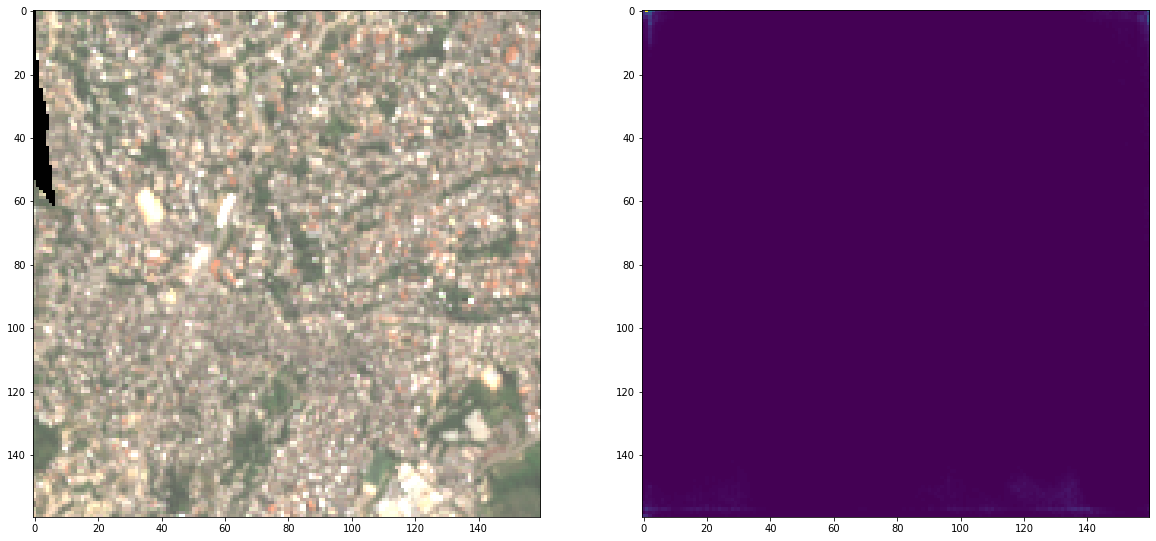

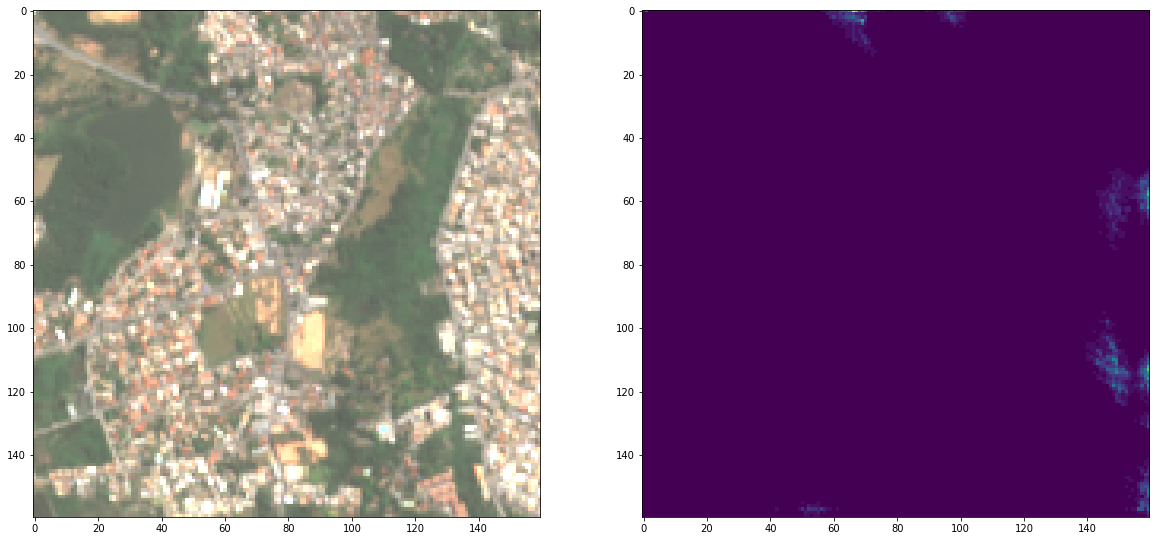

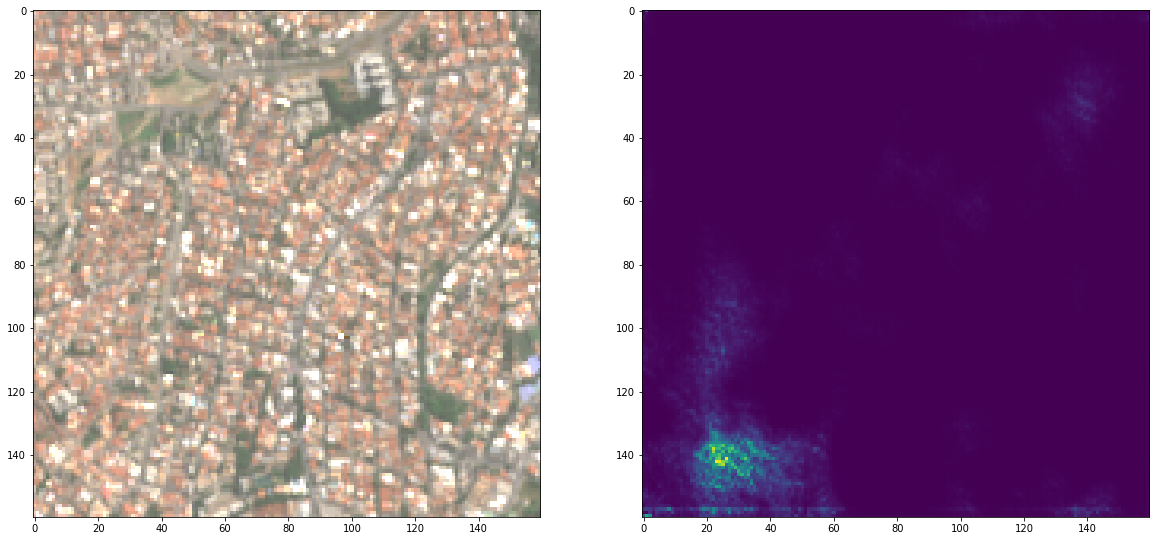

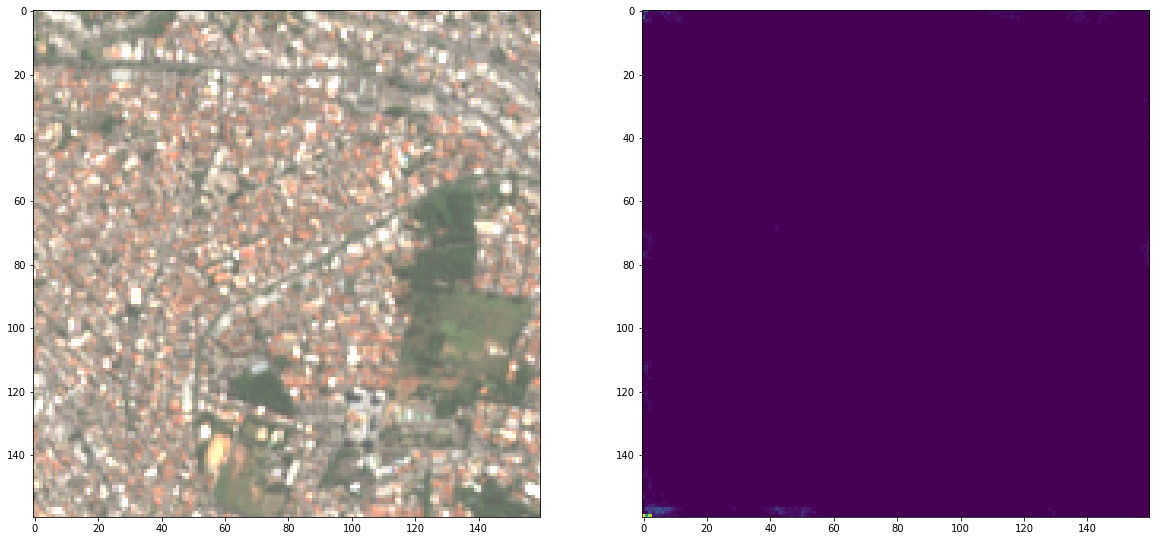

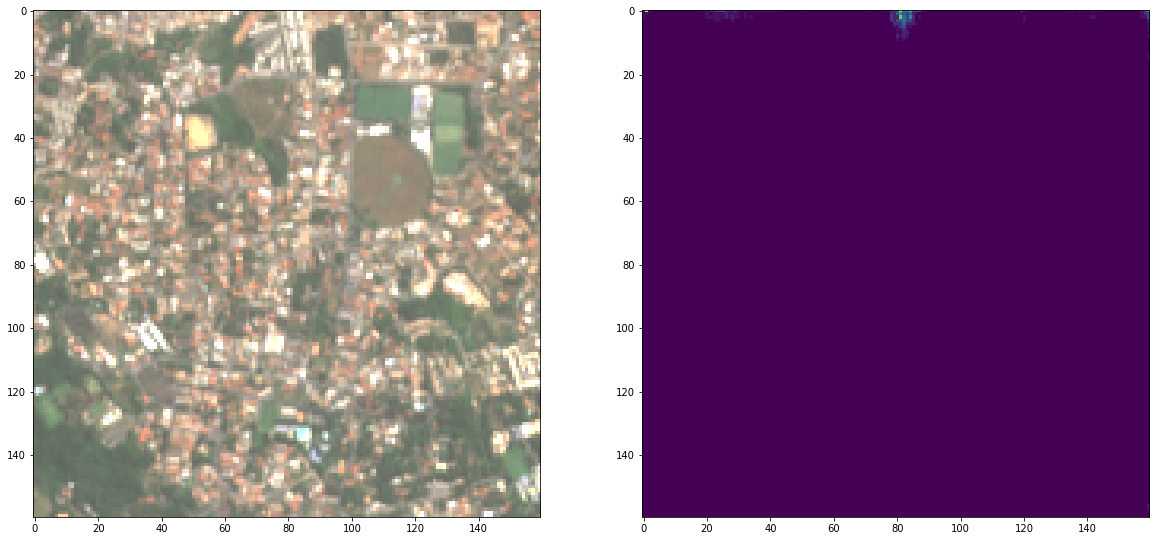

In [24]:
plot_data_results(num_samples=5, fig_size=(5, 5), predict_config=predict_config, img_ch =2,n_bands=3)

Subida al bucket 

*Uploading the images results to the bucket*

In [37]:
RESULTS_folder=os.path.join(BASE_PATH,'dataset/data_results',ZONE,YEAR_PREDICT,VERSION_UNET,str(SIZE)+"_"+str(STEP_SIZE))

#VM
BUCKET_RESULTS = f'gs://dym-org-techo-temp/techo-brasil/results/{ZONE}/{VERSION_UNET}/poligonize/{str(SIZE)}_{str(STEP_SIZE)}/'
#Colab
#BUCKET_RESULTS = f'gs://dym-datasets-public/techo-brasil/results/{ZONE}/{VERSION_UNET}/poligonize/{str(SIZE)}_{str(STEP_SIZE)}/'

!gsutil -m cp -r $RESULTS_folder $BUCKET_RESULTS

Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_8_14.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_9_15.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000014848_15_92.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000014848_24_88.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_25.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_5_17.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000014848_23_87.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_12_13.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_re

Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_8_8.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_17_9.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000014848_15_89.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_18_12.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_17.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_9_6.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_23_10.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_15_24.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_resu

Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_6_13.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_9_17.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_9_16.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_19_16.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000014848_25_88.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_10_7.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_21_19.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_1_12.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_resu

Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_12.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_11_20.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_6_18.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_8.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_6_17.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_20_10.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_8_18.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_17_4.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_resu

Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_22_10.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_23.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_18_21.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_16_13.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_6_16.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_13_12.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_5_12.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_18_6.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_re

Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_3.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_15_21.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_7_16.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_18_22.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_21.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_15_17.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_14_14.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_results/BH/2022/v1/160_160/0000000000-0000029696_15_5.tif [Content-Type=image/tiff]...
Copying file://./../dataset/data_re

# Post procesamiento/ Post processing

En esta etapa se aplican los siguientes métodos de post-procesamiento a los resultados de la predicción realizada por el modelo:

* Filtrado por umbral
* Poligonizado

In this stage, we aplied the following post proccessing methods to the prediction results:

* *Threshold filtering*
* *Polygonized*

## Filtrado por umbral/ Threshold filtering
En este proceso se realiza un filtrado de las imágenes de predicción. Se aplica un umbral a los valores de los píxeles, que representan la probabilidad (valores entre 0 y 1) de detectar el objeto de interés, quedandonos así con los de mayor precisión.

In this process we filter the results images by applying a threshold over the probabilities values, saving those which are higher than the threshold value.

In [51]:
thr=str(int(10*THR))
filtered_folder=f'./../dataset/data_results/{ZONE}/{YEAR_PREDICT}/{VERSION_UNET}/filtered_up/{str(SIZE)}_{str(STEP_SIZE)}_thr{thr}'
filter_by_max_prob(input_dir  = f'./../dataset/data_results/{ZONE}/{YEAR_PREDICT}/{VERSION_UNET}/{str(SIZE)}_{str(STEP_SIZE)}',#predict_config.results_path,
                   output_dir = filtered_folder,
                   threshold  = THR)

100%|##########| 361/361 [00:00<00:00, 373.60it/s]


## **Poligonizado/ Polygonized**

Aquí se crea un archivo vectorial (.GPKG) con polígonos de los resultados filtrados.

*Here the filtered results are converted into a vector file with polygons.*


In [52]:
poligonized_folder=f'./../dataset/data_results/{ZONE}/{YEAR_PREDICT}/{VERSION_UNET}/poligonize/'
!mkdir -p $poligonized_folder

In [53]:
output_path=f'./../dataset/data_results/{ZONE}/{YEAR_PREDICT}/{VERSION_UNET}/poligonize/poligonize_{ZONE}_{INFO}_thr{thr}_{str(SIZE)}_{str(STEP_SIZE)}_{VERSION_UNET}.gpkg'
polygonize(threshold=THR,
           input_dir=filtered_folder,
           output=output_path)

Dissolve: 100%|##########| 1/1 [00:00<00:00,  1.66it/s]


## Filtro de área mínima / Minimum area filter

Aplicamos un filtro para eliminar aquellos poligonos de resultados que son muy pequeños y que se producen por pequeñas fluctuaciones.

*We apply a filter to delete small area polygons produced by little fluctuations.*

Cambiamos la proyección del archivo vectorial de resultados a UTM para poder calcular el área de los polígonos.

*We reproject the results vector file to UTM. This allows to calculate the polygons area.*

In [54]:
src_file = f'./../dataset/data_results/{ZONE}/{YEAR_PREDICT}/{VERSION_UNET}/poligonize/poligonize_{ZONE}_{INFO}_thr{thr}_{str(SIZE)}_{str(STEP_SIZE)}_{VERSION}.gpkg'#output_path
dst_file = src_file[:-5] + "_utm.gpkg"

!ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32616 -f 'GPKG' $dst_file $src_file

In [55]:
input_ = dst_file
output_ = input_[:-5] + "_up"+str(min_area)+".gpkg"

Realizamos una consulta para conocer el nombre de la tabla de atributos de los resultados.

*We ask for the attribute table name of the results vector file.*

In [56]:
!ogrinfo -al -so $dst_file 

INFO: Open of `./../dataset/data_results/BH/2022/v1/poligonize/poligonize_BH_classA_thr3_160_160_v1_utm.gpkg'
      using driver `GPKG' successful.

Layer name: poligonize_BH_classA_thr3_160_160_v1
Geometry: Polygon
Feature Count: 850
Extent: (5315283.632509, -2940429.382623) - (5377532.475824, -2900920.920530)
Layer SRS WKT:
PROJCRS["WGS 84 / UTM zone 16N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 16N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-87,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],

Aplicamos el filtro de area minima.

*The minimum area filter is applied.*

In [116]:
tabla = input_.split("/",-1)[-1].replace('.gpkg','').replace('_utm','')
query_sql = "SELECT * FROM "+tabla+" m WHERE ST_Area(geom) > "+str(min_area)             

!ogr2ogr -t_srs EPSG:32616 -f "GPKG" -sql "$query_sql" -dialect SQLITE -nln results $output_ $input_
    